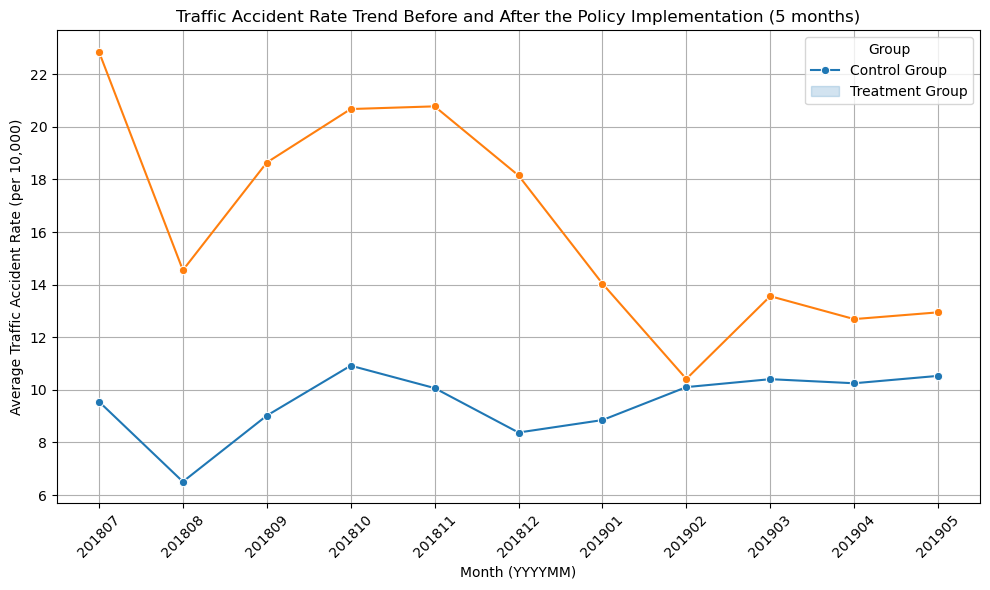

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# 加载交通事故数据
df = pd.read_excel("TrafficAccident.xlsx", dtype={'COD_DIS': np.int32, 'COD_BAR': np.int32})

# 提取事故率列名（格式为YYYYMM_rate）
accident_rate_cols = [col for col in df.columns if '_rate' in col]

# 将数据转换为长格式
df_long = pd.melt(df, id_vars=['COD_DIS', 'COD_BAR'], value_vars=accident_rate_cols,
                  var_name='DATE', value_name='ACCIDENT_RATE')

# 去除 '_rate' 后缀，并将日期转换为YYYYMM格式
df_long['DATE'] = df_long['DATE'].str.replace('_rate', '', regex=False)

# 提取年月信息
df_long['YEAR'] = df_long['DATE'].str[:4].astype(int)  # 提取年份
df_long['MONTH'] = df_long['DATE'].str[4:6].astype(int)  # 提取月份

# 确保 COD_BAR 列为字符串类型
df_long['COD_BAR'] = df_long['COD_BAR'].astype(str).str.zfill(3)  # 填充为三位数

# 创建 `treatment` 列：假设 COD_BAR 完全等于 '011', '012', '013', '014', '015', '016' 为处理组
df_long['treatment'] = df_long['COD_BAR'].isin(['011', '012', '013', '014', '015', '016']).astype(int)

# 创建时间变量，表示政策实施前后
df_long['after'] = (df_long['DATE'] >= '201812').astype(int)

# 选择政策实施前后的5个月的数据（政策前2个月和政策后3个月）
# 201807:201812为政策前的5个月，201901:201905为政策后的5个月
df_filtered = df_long[((df_long['DATE'] >= '201807') & (df_long['DATE'] <= '201812')) | 
                      ((df_long['DATE'] >= '201901') & (df_long['DATE'] <= '201905'))]

# 计算每个月份的平均交通事故率，按处理组划分
avg_accident_rate = df_filtered.groupby(['DATE', 'treatment'])['ACCIDENT_RATE'].mean().reset_index()

# 绘制时间趋势图
plt.figure(figsize=(10, 6))

# 绘制处理组和对照组的趋势
sns.lineplot(data=avg_accident_rate, x='DATE', y='ACCIDENT_RATE', hue='treatment', marker='o')

# 添加标题和标签
plt.title('Traffic Accident Rate Trend Before and After the Policy Implementation (5 months)')
plt.xlabel('Month (YYYYMM)')
plt.ylabel('Average Traffic Accident Rate (per 10,000)')
plt.xticks(rotation=45)
plt.legend(title='Group', labels=["Control Group", "Treatment Group"])
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()


In [39]:
import pandas as pd

# 加载交通事故数据
traffic_data = pd.read_excel('TrafficAccident.xlsx', sheet_name=None)

# 获取所有的工作表
accident_data = traffic_data['Sheet1']  # 假设数据在Sheet1中

# 只保留有用列（大区ID，小区ID，barrio名称和交通事故率列）
accident_data = accident_data[['COD_DIS', 'COD_BAR', 'NOMBRE_BAR'] + [col for col in accident_data.columns if '_rate' in col]]

# 确保日期列的格式正确，去掉日期中的日部分
accident_data = accident_data.melt(id_vars=['COD_DIS', 'COD_BAR', 'NOMBRE_BAR'], 
                                   var_name='Date', value_name='accident_rate_melted')

# 格式化日期列（从YYYYMM_rate转为日期格式，并去掉日部分）
accident_data['Date'] = pd.to_datetime(accident_data['Date'].str[:6], format='%Y%m')

# 只保留年月（YYYY-MM）格式
accident_data['Date'] = accident_data['Date'].dt.to_period('M')

# 加载社会因子数据
social_data = pd.read_excel('CONTROL_ADD.xlsx', sheet_name=None)

# 合并所有社会因子数据工作表，去除重复列
social_factors = pd.DataFrame()
for sheet_name, sheet_data in social_data.items():
    # 只保留有用列
    relevant_columns = ['COD_DIS', 'COD_BAR', 'NOMBRE_BAR'] + [col for col in sheet_data.columns if '20' in str(col)]
    sheet_data = sheet_data[relevant_columns]
    
    # 确保日期列的格式正确，去掉日期中的日部分
    sheet_data = sheet_data.melt(id_vars=['COD_DIS', 'COD_BAR', 'NOMBRE_BAR'],
                                 var_name='Date', value_name=sheet_name.lower())
    sheet_data['Date'] = pd.to_datetime(sheet_data['Date'].str.extract(r'(\d{4}_\d{2})')[0], format='%Y_%m')
    
    # 只保留年月（YYYY-MM）格式
    sheet_data['Date'] = sheet_data['Date'].dt.to_period('M')
    
    # 合并到social_factors，去除重复的 NOMBRE_BAR 列
    if social_factors.empty:
        social_factors = sheet_data
    else:
        social_factors = pd.merge(social_factors, sheet_data.drop(columns=['NOMBRE_BAR']), on=['COD_DIS', 'COD_BAR', 'Date'], how='outer')

# 合并所有数据
merged_data = pd.merge(accident_data, social_factors, on=['COD_DIS', 'COD_BAR', 'Date'], how='left')

# 打印合并后的数据
print(merged_data.head())



   COD_DIS  COD_BAR NOMBRE_BAR_x     Date  accident_rate_melted NOMBRE_BAR_y  \
0        1       11      Palacio  2018-01                 13.05      Palacio   
1        1       12  Embajadores  2018-01                  6.82  Embajadores   
2        1       13       Cortes  2018-01                 25.65       Cortes   
3        1       14     Justicia  2018-01                 25.57     Justicia   
4        1       15  Universidad  2018-01                 16.03  Universidad   

   education  income    population  transport   commercial  residential  \
0  68.885251  23.062  15636.377392  38.069222   422.476086    22.929899   
1  60.093677  23.062  43950.773425  36.732709   480.785649    58.333302   
2  73.469163  23.062  17782.497341  64.154587   699.473055    46.774200   
3  74.788877  23.062  23268.415440  37.839336   833.091770    56.962002   
4  69.849191  23.062  33552.839113  49.539500  1206.716588    59.000000   

   roadvolume  
0  440.610578  
1  378.648299  
2  791.445644  
3  3

In [40]:

# 保存回归结果为CSV文件
csv_file_path = 'merged_data.csv'
merged_data.to_csv(csv_file_path)

# 返回保存的CSV文件路径
csv_file_path

'merged_data.csv'

In [49]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 假设数据已经加载到 merged_data 中
# 确保 COD_BAR 列为字符串类型
merged_data['COD_BAR'] = merged_data['COD_BAR'].astype(str).str.zfill(3)  # 填充为三位数

# 创建 `treatment` 列：假设 COD_BAR 完全等于 '011', '012', '013', '014', '015', '016' 为处理组
merged_data['treatment'] = merged_data['COD_BAR'].isin(['011', '012', '013', '014', '015', '016']).astype(int)

# 创建 Date_num 列（年月数值表示）
merged_data['Date_num'] = merged_data['Date'].dt.year * 100 + merged_data['Date'].dt.month

# 确保 `Date_num` 列为整数类型（如果它还不是整数）
merged_data['Date_num'] = merged_data['Date_num'].astype(int)

# 创建时间虚拟变量：政策前后的月份
months_before = [201807, 201808, 201809, 201810, 201811]  # 政策前
months_after = [201812,201901, 201902, 201903, 201904, 201905]   # 政策后

# 创建 policy_month 列，表示每个时间点是否为政策前或政策后
merged_data['policy_month'] = np.nan
merged_data.loc[merged_data['Date_num'].isin(months_before), 'policy_month'] = 'pre'
merged_data.loc[merged_data['Date_num'].isin(months_after), 'policy_month'] = 'post'

# 创建交互项：处理组在不同月份的变化（使用 policy_month 和 treatment 的交互项）
for month in months_before:
    merged_data[f'treatment_pre_{month}'] = merged_data['treatment'] * (merged_data['Date_num'] == month)

for month in months_after:
    merged_data[f'treatment_post_{month}'] = merged_data['treatment'] * (merged_data['Date_num'] == month)

# 检查是否成功创建交互项列
print(merged_data.columns)

# 回归模型：包括交互项（treatment * pre 和 treatment * post），时间固定效应和地区固定效应
# 假设控制变量名称已变为小写，并且存在
formula = 'accident_rate_melted ~ ' + ' + '.join([f'treatment_pre_{month}' for month in months_before]) + ' + ' + ' + '.join([f'treatment_post_{month}' for month in months_after]) + ' + education + income + population + transport + commercial + residential  + C(COD_BAR) + C(Date_num)'

# 执行回归
model = smf.ols(formula=formula, data=merged_data).fit()

# 打印回归结果
print(model.summary())




Index(['COD_DIS', 'COD_BAR', 'NOMBRE_BAR_x', 'Date', 'accident_rate_melted',
       'NOMBRE_BAR_y', 'education', 'income', 'population', 'transport',
       'commercial', 'residential', 'roadvolume', 'treatment', 'Date_num',
       'policy_month', 'treatment_pre_201807', 'treatment_pre_201808',
       'treatment_pre_201809', 'treatment_pre_201810', 'treatment_pre_201811',
       'treatment_post_201901', 'treatment_post_201902',
       'treatment_post_201903', 'treatment_post_201904',
       'treatment_post_201905', 'treatment_post_201812'],
      dtype='object')
                             OLS Regression Results                             
Dep. Variable:     accident_rate_melted   R-squared:                       0.688
Model:                              OLS   Adj. R-squared:                  0.680
Method:                   Least Squares   F-statistic:                     82.33
Date:                  Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                     

C:\Users\czy01\AppData\Local\Temp\ipykernel_4896\3423072071.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'pre' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.loc[merged_data['Date_num'].isin(months_before), 'policy_month'] = 'pre'


In [50]:
import statsmodels.formula.api as smf

regression_results_df = pd.DataFrame(model.params, columns=['Coefficient'])
regression_results_df['Std Err'] = model.bse
regression_results_df['t-Statistic'] = model.tvalues
regression_results_df['P-Value'] = model.pvalues

# 保存回归结果为CSV文件
csv_file_path = 'regression_results2.csv'
regression_results_df.to_csv(csv_file_path)

# 返回保存的CSV文件路径
csv_file_path

'regression_results2.csv'

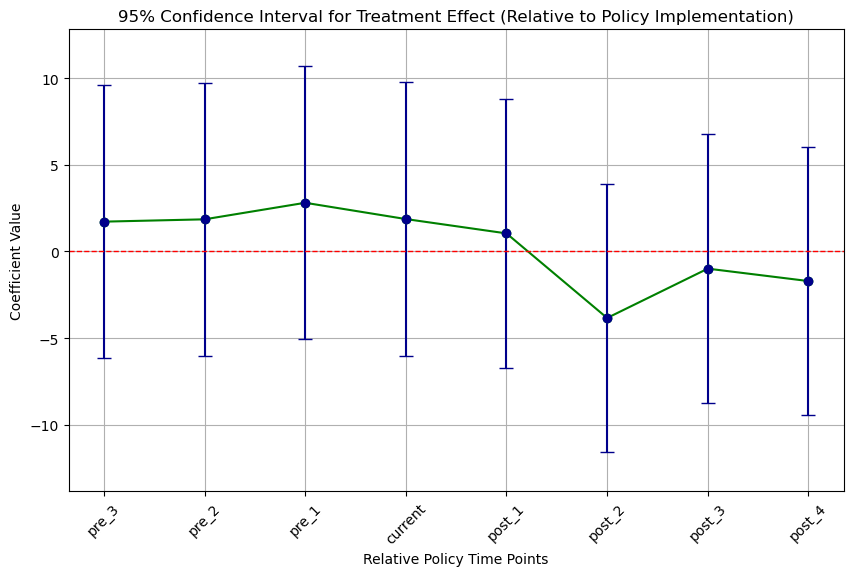

In [58]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

regression_result2018 = pd.read_csv('regression_result2018.csv')


# 提取系数的日期和数值
months = [ '201809', '201810', '201811', '201812','201901', '201902', '201903', '201904']
coef_values = regression_result2018['Coefficient'].values  # 获取回归系数
std_errors = regression_result2018['Std Err'].values

coef_values = np.array(coef_values, dtype=float)
std_errors = np.array(std_errors, dtype=float)

# 假设标准误为系数的±10%（实际中应根据数据提供）
# 计算95%置信区间
z_value = 1.96  # 95%置信区间的Z值
conf_values = [(coef - z_value * std, coef + z_value * std) for coef, std in zip(coef_values, std_errors)]

# 相对政策的月份，"current"是政策实施月份
time_labels = ['pre_3', 'pre_2', 'pre_1', 'current', 'post_1', 'post_2', 'post_3', 'post_4']  # 用于横轴标签
if len(time_labels) != len(coef_values):
    raise ValueError("The length of time_labels does not match the length of coef_values")
# 绘制置信区间图
plt.figure(figsize=(10, 6))

# 绘制系数和置信区间
plt.errorbar(time_labels, coef_values, 
             yerr=[[coef_values[i] - conf_values[i][0] for i in range(len(months))], 
                   [conf_values[i][1] - coef_values[i] for i in range(len(months))]],
             fmt='o', capsize=5, color='darkblue',label='Coefficient with 95% CI')

plt.plot(time_labels, coef_values, linestyle='-', color='green', marker='o', label='Trend Line')

plt.axhline(0, color='red', linestyle='--', linewidth=1)
# 添加标题和标签
plt.title('95% Confidence Interval for Treatment Effect (Relative to Policy Implementation)')
plt.xlabel('Relative Policy Time Points')
plt.ylabel('Coefficient Value')

# 调整纵轴范围，确保纵轴的每个单位跨度为2
plt.ylim(min(coef_values) - 10, max(coef_values) + 10)  # 拉大纵轴范围

# 旋转X轴标签
plt.xticks(rotation=45)

# 显示网格和紧凑布局
plt.grid(True)


# 显示图表
plt.show()



